# Optimization of CNN - TPE

In this notebook, we will optimize the hyperparameters of a CNN using the define-by-run model from Optuna.

In [1]:
# For reproducible results.
# See: 
# https://keras.io/getting_started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development

import os
os.environ['PYTHONHASHSEED'] = '0'

import numpy as np
import tensorflow as tf
import random as python_random

# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.
np.random.seed(123)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.
python_random.seed(123)

# The below set_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see:
# https://www.tensorflow.org/api_docs/python/tf/random/set_seed
tf.random.set_seed(1234)

In [2]:

import itertools
from functools import partial

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [5]:
from keras.utils.np_utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam, RMSprop

In [6]:
import optuna

## Data Preparation

The dataset contains information about images, each image is a hand-written digit. The aim is to have the computer predict which digit was written by the person, automatically, by "looking" at the image.

Each image is 28 pixels in height and 28 pixels in width (28 x 28), making a total of 784 pixels. Each pixel value is an integer between 0 and 255, indicating the darkness in a gray-scale of that pixel.

The data is stored in a dataframe where each each pixel is a column (so it is flattened and not in the 28 x 28 format).

The data set the has 785 columns. The first column, called "label", is the digit that was drawn by the user. The rest of the columns contain the pixel-values of the associated image.

In [8]:
# Load the data

data = pd.read_csv("../../data/processed/mnist.csv")

# first column is the target, the rest of the columns
# are the pixels of the image

# each row is 1 image
data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
# split dataset into a train and test set

X_train, X_test, y_train, y_test = train_test_split(
    data.drop(['label'], axis=1), # the images
    data['label'], # the target
    test_size = 0.1,
    random_state=0)

X_train.shape, X_test.shape

((37800, 784), (4200, 784))

Text(0, 0.5, 'Number of images')

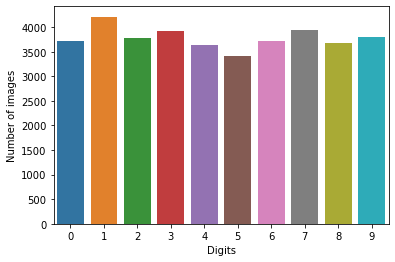

In [10]:
# number of images for each digit

g = sns.countplot(x=y_train)
plt.xlabel('Digits')
plt.ylabel('Number of images')

There are roughly the same amount of images for each of the 10 digits.

### Image re-scaling

We re-scale data for the CNN, between 0 and 1.

In [11]:
# Re-scale the data

# 255 is the maximum value a pixel can take

X_train = X_train / 255
X_test = X_test / 255

### Reshape

The images were stored in a pandas dataframe as 1-D vectors of 784 values. For a CNN with Keras, we need tensors with the following dimensions: width x height x channel.

Thus, we reshape all data to 28 x 2 8 x 1, 3-D matrices.

The 3rd dimension corresponds to the channel. RGB images have 3 channels. MNIST images are in gray-scale, thus they have only one channel in the 3rd dimension.

In [12]:
# Reshape image in 3 dimensions:
# height: 28px X width: 28px X channel: 1 

X_train = X_train.values.reshape(-1,28,28,1)
X_test = X_test.values.reshape(-1,28,28,1)

### Target encoding

In [13]:
# the target is 1 variable with the 9 different digits
# as values

y_train.unique()

array([2, 0, 7, 4, 3, 5, 9, 6, 8, 1])

In [14]:
# For Keras, we need to create 10 dummy variables,
# one for each digit

# Encode labels to one hot vectors (ex : digit 2 -> [0,0,1,0,0,0,0,0,0,0])

y_train = to_categorical(y_train, num_classes = 10)
y_test = to_categorical(y_test, num_classes = 10)

# the new target
y_train

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

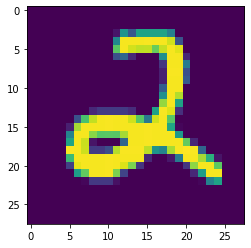

In [15]:
# Some image examples 

g = plt.imshow(X_train[0][:,:,0])

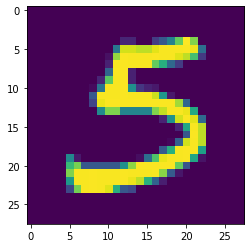

In [16]:
# Some image examples 

g = plt.imshow(X_train[10][:,:,0])

## Define-by-Run design

We create the CNN and add the sampling space for the hyperparameters as we go. This is the Desing-by-run concept.

In [17]:
# we will save the model with this name
path_best_model = 'cnn_model.h5'

# starting point for the optimization
best_accuracy = 0

In [18]:
# function to create the CNN

def objective(trial):

    # Start construction of a Keras Sequential model.
    model = Sequential()

    # Convolutional layers.

    # We add the different number of conv layers in the following loop:
    num_conv_layers = trial.suggest_int('num_conv_layers', 1, 3)

    for i in range(num_conv_layers):
        
        # NOTE: As per the below configuration, the parameters of each
        # convolutional layer will be identical.
        
        # if we want different parameters in each layer, check next
        # notebook

        model.add(Conv2D(
            filters=trial.suggest_categorical('filters', [16, 32, 64]),
            kernel_size=trial.suggest_categorical('kernel_size', [3, 5]),
            strides=trial.suggest_categorical('strides', [1, 2]),
            activation=trial.suggest_categorical(
                'activation', ['relu', 'tanh']),
            padding='same',
        ))

    # we could also optimize these parameters if we wanted:
    model.add(MaxPool2D(pool_size=2, strides=2))

    # Flatten the 4-rank output of the convolutional layers
    # to 2-rank that can be input to a fully-connected Dense layer.
    model.add(Flatten())

    # Add fully-connected Dense layers.
    # The number of layers is a hyper-parameter we want to optimize.
    # We add the different number of layers in the following loop:

    num_dense_layers = trial.suggest_int('num_dense_layers', 1, 3)

    for i in range(num_dense_layers):

        # Add the dense fully-connected layer to the model.
        # This has two hyper-parameters we want to optimize:
        # The number of nodes (neurons) and the activation function.
        model.add(Dense(
            units=trial.suggest_int('units', 5, 512),
            activation=trial.suggest_categorical(
                'activation', ['relu', 'tanh']),
        ))

    # Last fully-connected dense layer with softmax-activation
    # for use in classification.
    model.add(Dense(10, activation='softmax'))

    # Use the Adam method for training the network.
    optimizer_name = trial.suggest_categorical(
        'optimizer_name', ['Adam', 'RMSprop'])

    if optimizer_name == 'Adam':
        optimizer = Adam(lr=trial.suggest_float('learning_rate',  1e-6, 1e-2))
    else:
        optimizer = RMSprop(
            lr=trial.suggest_float('learning_rate',  1e-6, 1e-2),
            momentum=trial.suggest_float('momentum',  0.1, 0.9),
        )

    # In Keras we need to compile the model so it can be trained.
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # train the model
    # we use 3 epochs to be able to run the notebook in a "reasonable"
    # time. If we increase the epochs, we will have better performance
    # this could be another parameter to optimize in fact.
    history = model.fit(
        x=X_train,
        y=y_train,
        epochs=3,
        batch_size=128,
        validation_split=0.1,
    )

    # Get the classification accuracy on the validation-set
    # after the last training-epoch.
    accuracy = history.history['val_accuracy'][-1]

    # Save the model if it improves on the best-found performance.
    # We use the global keyword so we update the variable outside
    # of this function.
    global best_accuracy

    # If the classification accuracy of the saved model is improved ...
    if accuracy > best_accuracy:
        # Save the new model to harddisk.
        # Training CNNs is costly, so we want to avoid having to re-train
        # the network with the best found parameters. We save it instead
        # as we search for the best hyperparam space.
        model.save(path_best_model)

        # Update the classification accuracy.
        best_accuracy = accuracy

    # Delete the Keras model with these hyper-parameters from memory.
    del model

    # Remember that Scikit-optimize always minimizes the objective
    # function, so we need to negate the accuracy (because we want
    # the maximum accuracy)
    return accuracy

In [19]:
# we need this to store the search
# we will use it in the following notebook

study_name = "cnn_study"  # unique identifier of the study.
storage_name = "sqlite:///{}.db".format(study_name)

In [20]:
study = optuna.create_study(
    direction='maximize',
    study_name=study_name,
    storage=storage_name,
    load_if_exists=True,
)

study.optimize(objective, n_trials=30)

[I 2022-10-31 05:21:17,655] A new study created in RDB with name: cnn_study
2022-10-31 05:21:17.990316: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/santiago/anaconda3/envs/hyperparameter_optimization_for_machine_learning/lib/python3.9/site-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Epoch 1/3
266/266 [==============================] - 478s 2s/step - loss: 0.5601 - accuracy: 0.8258 - val_loss: 0.1148 - val_accuracy: 0.9653
Epoch 2/3
266/266 [==============================] - 390s 1s/step - loss: 0.1232 - accuracy: 0.9668 - val_loss: 0.1069 - val_accuracy: 0.9704
Epoch 3/3
266/266 [==============================] - 367s 1s/step - loss: 0.0946 - accuracy: 0.9731 - val_loss: 0.1144 - val_accuracy: 0.9720


[I 2022-10-31 05:41:55,119] Trial 0 finished with value: 0.9719576835632324 and parameters: {'num_conv_layers': 3, 'filters': 64, 'kernel_size': 5, 'strides': 1, 'activation': 'relu', 'num_dense_layers': 3, 'units': 127, 'optimizer_name': 'RMSprop', 'learning_rate': 0.005078127117870548, 'momentum': 0.2639156658202595}. Best is trial 0 with value: 0.9719576835632324.
/home/santiago/anaconda3/envs/hyperparameter_optimization_for_machine_learning/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/3
266/266 [==============================] - 15s 56ms/step - loss: 0.2805 - accuracy: 0.9153 - val_loss: 0.1693 - val_accuracy: 0.9505
Epoch 2/3
266/266 [==============================] - 16s 59ms/step - loss: 0.1069 - accuracy: 0.9665 - val_loss: 0.1154 - val_accuracy: 0.9638
Epoch 3/3
266/266 [==============================] - 16s 60ms/step - loss: 0.0723 - accuracy: 0.9774 - val_loss: 0.1180 - val_accuracy: 0.9696


[I 2022-10-31 05:42:43,204] Trial 1 finished with value: 0.9695767164230347 and parameters: {'num_conv_layers': 1, 'filters': 32, 'kernel_size': 3, 'strides': 1, 'activation': 'tanh', 'num_dense_layers': 3, 'units': 399, 'optimizer_name': 'Adam', 'learning_rate': 0.0022292131911345802}. Best is trial 0 with value: 0.9719576835632324.


Epoch 1/3
266/266 [==============================] - 18s 67ms/step - loss: 3.0371 - accuracy: 0.1009 - val_loss: 2.6794 - val_accuracy: 0.0868
Epoch 2/3
266/266 [==============================] - 18s 67ms/step - loss: 2.9205 - accuracy: 0.1019 - val_loss: 2.7692 - val_accuracy: 0.1037
Epoch 3/3
266/266 [==============================] - 20s 75ms/step - loss: 2.8864 - accuracy: 0.1011 - val_loss: 2.7082 - val_accuracy: 0.0937


[I 2022-10-31 05:43:40,285] Trial 2 finished with value: 0.09365079551935196 and parameters: {'num_conv_layers': 2, 'filters': 64, 'kernel_size': 5, 'strides': 2, 'activation': 'tanh', 'num_dense_layers': 3, 'units': 450, 'optimizer_name': 'RMSprop', 'learning_rate': 0.004876999052290255, 'momentum': 0.19507426356376564}. Best is trial 0 with value: 0.9719576835632324.


Epoch 1/3
266/266 [==============================] - 12s 44ms/step - loss: 2.5241 - accuracy: 0.0999 - val_loss: 2.4879 - val_accuracy: 0.1037
Epoch 2/3
266/266 [==============================] - 11s 41ms/step - loss: 2.4246 - accuracy: 0.1034 - val_loss: 2.5977 - val_accuracy: 0.1045
Epoch 3/3
266/266 [==============================] - 11s 41ms/step - loss: 2.4289 - accuracy: 0.1048 - val_loss: 2.3943 - val_accuracy: 0.0937


[I 2022-10-31 05:44:15,186] Trial 3 finished with value: 0.09365079551935196 and parameters: {'num_conv_layers': 3, 'filters': 64, 'kernel_size': 3, 'strides': 2, 'activation': 'tanh', 'num_dense_layers': 3, 'units': 400, 'optimizer_name': 'Adam', 'learning_rate': 0.00924197473215606}. Best is trial 0 with value: 0.9719576835632324.


Epoch 1/3
266/266 [==============================] - 17s 62ms/step - loss: 0.2472 - accuracy: 0.9213 - val_loss: 0.0720 - val_accuracy: 0.9762
Epoch 2/3
266/266 [==============================] - 16s 60ms/step - loss: 0.0702 - accuracy: 0.9778 - val_loss: 0.0779 - val_accuracy: 0.9780
Epoch 3/3
266/266 [==============================] - 16s 58ms/step - loss: 0.0464 - accuracy: 0.9855 - val_loss: 0.0791 - val_accuracy: 0.9786


[I 2022-10-31 05:45:04,916] Trial 4 finished with value: 0.9785714149475098 and parameters: {'num_conv_layers': 2, 'filters': 64, 'kernel_size': 5, 'strides': 2, 'activation': 'relu', 'num_dense_layers': 2, 'units': 106, 'optimizer_name': 'RMSprop', 'learning_rate': 0.0008741507492360411, 'momentum': 0.6118593311201581}. Best is trial 4 with value: 0.9785714149475098.


Epoch 1/3
266/266 [==============================] - 10s 36ms/step - loss: 0.1780 - accuracy: 0.9442 - val_loss: 0.0932 - val_accuracy: 0.9722
Epoch 2/3
266/266 [==============================] - 9s 35ms/step - loss: 0.0578 - accuracy: 0.9822 - val_loss: 0.0844 - val_accuracy: 0.9754
Epoch 3/3
266/266 [==============================] - 9s 35ms/step - loss: 0.0420 - accuracy: 0.9865 - val_loss: 0.0761 - val_accuracy: 0.9807


[I 2022-10-31 05:45:34,641] Trial 5 finished with value: 0.9806878566741943 and parameters: {'num_conv_layers': 1, 'filters': 32, 'kernel_size': 5, 'strides': 1, 'activation': 'relu', 'num_dense_layers': 2, 'units': 80, 'optimizer_name': 'Adam', 'learning_rate': 0.007540784235572642}. Best is trial 5 with value: 0.9806878566741943.


Epoch 1/3
266/266 [==============================] - 133s 501ms/step - loss: 0.1931 - accuracy: 0.9405 - val_loss: 0.0941 - val_accuracy: 0.9730
Epoch 2/3
266/266 [==============================] - 132s 496ms/step - loss: 0.0521 - accuracy: 0.9836 - val_loss: 0.0653 - val_accuracy: 0.9820
Epoch 3/3
266/266 [==============================] - 133s 498ms/step - loss: 0.0294 - accuracy: 0.9917 - val_loss: 0.0589 - val_accuracy: 0.9823


[I 2022-10-31 05:52:14,168] Trial 6 finished with value: 0.982275128364563 and parameters: {'num_conv_layers': 3, 'filters': 32, 'kernel_size': 5, 'strides': 1, 'activation': 'tanh', 'num_dense_layers': 1, 'units': 298, 'optimizer_name': 'Adam', 'learning_rate': 0.0007934015746715985}. Best is trial 6 with value: 0.982275128364563.


Epoch 1/3
266/266 [==============================] - 73s 274ms/step - loss: 0.2121 - accuracy: 0.9357 - val_loss: 0.1172 - val_accuracy: 0.9651
Epoch 2/3
266/266 [==============================] - 74s 277ms/step - loss: 0.0710 - accuracy: 0.9785 - val_loss: 0.0887 - val_accuracy: 0.9735
Epoch 3/3
266/266 [==============================] - 72s 269ms/step - loss: 0.0444 - accuracy: 0.9869 - val_loss: 0.0763 - val_accuracy: 0.9783


[I 2022-10-31 05:55:53,679] Trial 7 finished with value: 0.9783068895339966 and parameters: {'num_conv_layers': 2, 'filters': 32, 'kernel_size': 5, 'strides': 1, 'activation': 'tanh', 'num_dense_layers': 1, 'units': 170, 'optimizer_name': 'Adam', 'learning_rate': 0.00176576877203124}. Best is trial 6 with value: 0.982275128364563.


Epoch 1/3
266/266 [==============================] - 146s 547ms/step - loss: 0.2160 - accuracy: 0.9322 - val_loss: 0.0809 - val_accuracy: 0.9754
Epoch 2/3
266/266 [==============================] - 145s 547ms/step - loss: 0.0503 - accuracy: 0.9843 - val_loss: 0.0583 - val_accuracy: 0.9844
Epoch 3/3
266/266 [==============================] - 3355s 13s/step - loss: 0.0300 - accuracy: 0.9903 - val_loss: 0.0491 - val_accuracy: 0.9873


[I 2022-10-31 06:56:42,126] Trial 8 finished with value: 0.9873015880584717 and parameters: {'num_conv_layers': 3, 'filters': 64, 'kernel_size': 3, 'strides': 1, 'activation': 'relu', 'num_dense_layers': 1, 'units': 176, 'optimizer_name': 'RMSprop', 'learning_rate': 0.00048271221055016877, 'momentum': 0.2894630905829889}. Best is trial 8 with value: 0.9873015880584717.


Epoch 1/3
266/266 [==============================] - 38s 132ms/step - loss: 0.2790 - accuracy: 0.9160 - val_loss: 0.1394 - val_accuracy: 0.9585
Epoch 2/3
266/266 [==============================] - 24s 89ms/step - loss: 0.0855 - accuracy: 0.9738 - val_loss: 0.0929 - val_accuracy: 0.9746
Epoch 3/3
266/266 [==============================] - 27s 103ms/step - loss: 0.0481 - accuracy: 0.9852 - val_loss: 0.0784 - val_accuracy: 0.9783


[I 2022-10-31 06:58:14,369] Trial 9 finished with value: 0.9783068895339966 and parameters: {'num_conv_layers': 2, 'filters': 16, 'kernel_size': 3, 'strides': 1, 'activation': 'tanh', 'num_dense_layers': 3, 'units': 152, 'optimizer_name': 'Adam', 'learning_rate': 0.0008541051379609068}. Best is trial 8 with value: 0.9873015880584717.


Epoch 1/3
266/266 [==============================] - 8s 26ms/step - loss: 0.3295 - accuracy: 0.8974 - val_loss: 0.2753 - val_accuracy: 0.9156
Epoch 2/3
266/266 [==============================] - 4s 16ms/step - loss: 0.1679 - accuracy: 0.9525 - val_loss: 0.1761 - val_accuracy: 0.9550
Epoch 3/3
266/266 [==============================] - 5s 18ms/step - loss: 0.1533 - accuracy: 0.9580 - val_loss: 0.1948 - val_accuracy: 0.9503


[I 2022-10-31 06:58:33,227] Trial 10 finished with value: 0.950264573097229 and parameters: {'num_conv_layers': 3, 'filters': 16, 'kernel_size': 3, 'strides': 2, 'activation': 'relu', 'num_dense_layers': 1, 'units': 264, 'optimizer_name': 'RMSprop', 'learning_rate': 0.003804417296081093, 'momentum': 0.8472140396187644}. Best is trial 8 with value: 0.9873015880584717.


Epoch 1/3
266/266 [==============================] - 74s 277ms/step - loss: 0.6046 - accuracy: 0.8447 - val_loss: 0.2815 - val_accuracy: 0.9119
Epoch 2/3
266/266 [==============================] - 88s 331ms/step - loss: 0.2166 - accuracy: 0.9357 - val_loss: 0.2012 - val_accuracy: 0.9439
Epoch 3/3
266/266 [==============================] - 81s 303ms/step - loss: 0.1415 - accuracy: 0.9581 - val_loss: 0.1526 - val_accuracy: 0.9574


[I 2022-10-31 07:02:38,380] Trial 11 finished with value: 0.9574074149131775 and parameters: {'num_conv_layers': 3, 'filters': 32, 'kernel_size': 3, 'strides': 1, 'activation': 'relu', 'num_dense_layers': 1, 'units': 275, 'optimizer_name': 'RMSprop', 'learning_rate': 4.643675489841712e-05, 'momentum': 0.4408445084699992}. Best is trial 8 with value: 0.9873015880584717.


Epoch 1/3
266/266 [==============================] - 69s 258ms/step - loss: 0.3284 - accuracy: 0.8976 - val_loss: 0.1129 - val_accuracy: 0.9706
Epoch 2/3
266/266 [==============================] - 58s 217ms/step - loss: 0.0773 - accuracy: 0.9778 - val_loss: 0.0903 - val_accuracy: 0.9749
Epoch 3/3
266/266 [==============================] - 61s 230ms/step - loss: 0.0505 - accuracy: 0.9853 - val_loss: 0.0844 - val_accuracy: 0.9762


[I 2022-10-31 07:05:48,785] Trial 12 finished with value: 0.976190447807312 and parameters: {'num_conv_layers': 3, 'filters': 32, 'kernel_size': 3, 'strides': 1, 'activation': 'relu', 'num_dense_layers': 1, 'units': 10, 'optimizer_name': 'Adam', 'learning_rate': 0.003094827527937078}. Best is trial 8 with value: 0.9873015880584717.


Epoch 1/3
266/266 [==============================] - 419s 2s/step - loss: 3.0438 - accuracy: 0.1000 - val_loss: 3.4661 - val_accuracy: 0.1079
Epoch 2/3
266/266 [==============================] - 437s 2s/step - loss: 2.8967 - accuracy: 0.1019 - val_loss: 2.7347 - val_accuracy: 0.1037
Epoch 3/3
266/266 [==============================] - 390s 1s/step - loss: 2.8819 - accuracy: 0.1018 - val_loss: 2.9057 - val_accuracy: 0.1037


[I 2022-10-31 07:26:35,496] Trial 13 finished with value: 0.10370370000600815 and parameters: {'num_conv_layers': 3, 'filters': 64, 'kernel_size': 5, 'strides': 1, 'activation': 'tanh', 'num_dense_layers': 2, 'units': 324, 'optimizer_name': 'RMSprop', 'learning_rate': 0.0064133279551809195, 'momentum': 0.4466097272762934}. Best is trial 8 with value: 0.9873015880584717.


Epoch 1/3
266/266 [==============================] - 28s 103ms/step - loss: 0.4983 - accuracy: 0.8613 - val_loss: 0.2578 - val_accuracy: 0.9243
Epoch 2/3
266/266 [==============================] - 25s 93ms/step - loss: 0.1931 - accuracy: 0.9433 - val_loss: 0.1839 - val_accuracy: 0.9450
Epoch 3/3
266/266 [==============================] - 28s 104ms/step - loss: 0.1312 - accuracy: 0.9620 - val_loss: 0.1363 - val_accuracy: 0.9630


[I 2022-10-31 07:27:56,736] Trial 14 finished with value: 0.9629629850387573 and parameters: {'num_conv_layers': 3, 'filters': 16, 'kernel_size': 3, 'strides': 1, 'activation': 'tanh', 'num_dense_layers': 1, 'units': 220, 'optimizer_name': 'Adam', 'learning_rate': 0.0001574315196434837}. Best is trial 8 with value: 0.9873015880584717.


Epoch 1/3
266/266 [==============================] - 82s 307ms/step - loss: 0.1904 - accuracy: 0.9382 - val_loss: 0.0876 - val_accuracy: 0.9743
Epoch 2/3
266/266 [==============================] - 75s 281ms/step - loss: 0.0469 - accuracy: 0.9847 - val_loss: 0.0552 - val_accuracy: 0.9860
Epoch 3/3
266/266 [==============================] - 81s 304ms/step - loss: 0.0283 - accuracy: 0.9908 - val_loss: 0.0684 - val_accuracy: 0.9852


[I 2022-10-31 07:31:56,119] Trial 15 finished with value: 0.9851852059364319 and parameters: {'num_conv_layers': 2, 'filters': 32, 'kernel_size': 5, 'strides': 1, 'activation': 'relu', 'num_dense_layers': 1, 'units': 336, 'optimizer_name': 'RMSprop', 'learning_rate': 0.0021017098156836007, 'momentum': 0.17327124407330768}. Best is trial 8 with value: 0.9873015880584717.


Epoch 1/3
266/266 [==============================] - 269s 1s/step - loss: 0.2769 - accuracy: 0.9141 - val_loss: 0.0795 - val_accuracy: 0.9780
Epoch 2/3
266/266 [==============================] - 228s 857ms/step - loss: 0.0560 - accuracy: 0.9835 - val_loss: 0.0632 - val_accuracy: 0.9839
Epoch 3/3
266/266 [==============================] - 207s 777ms/step - loss: 0.0362 - accuracy: 0.9889 - val_loss: 0.0664 - val_accuracy: 0.9847


[I 2022-10-31 07:43:42,627] Trial 16 finished with value: 0.9846560955047607 and parameters: {'num_conv_layers': 2, 'filters': 64, 'kernel_size': 5, 'strides': 1, 'activation': 'relu', 'num_dense_layers': 2, 'units': 497, 'optimizer_name': 'RMSprop', 'learning_rate': 0.0024017961640828396, 'momentum': 0.10394547700752102}. Best is trial 8 with value: 0.9873015880584717.


Epoch 1/3
266/266 [==============================] - 25s 93ms/step - loss: 0.2495 - accuracy: 0.9300 - val_loss: 0.1024 - val_accuracy: 0.9661
Epoch 2/3
266/266 [==============================] - 22s 83ms/step - loss: 0.0575 - accuracy: 0.9818 - val_loss: 0.0713 - val_accuracy: 0.9825
Epoch 3/3
266/266 [==============================] - 21s 80ms/step - loss: 0.0301 - accuracy: 0.9900 - val_loss: 0.0886 - val_accuracy: 0.9788


[I 2022-10-31 07:44:51,876] Trial 17 finished with value: 0.9788359999656677 and parameters: {'num_conv_layers': 1, 'filters': 64, 'kernel_size': 3, 'strides': 1, 'activation': 'relu', 'num_dense_layers': 1, 'units': 359, 'optimizer_name': 'RMSprop', 'learning_rate': 0.003464581314940457, 'momentum': 0.30681493690337863}. Best is trial 8 with value: 0.9873015880584717.


Epoch 1/3
266/266 [==============================] - 9s 24ms/step - loss: 0.3493 - accuracy: 0.8890 - val_loss: 0.1143 - val_accuracy: 0.9638
Epoch 2/3
266/266 [==============================] - 7s 25ms/step - loss: 0.1115 - accuracy: 0.9668 - val_loss: 0.1090 - val_accuracy: 0.9648
Epoch 3/3
266/266 [==============================] - 5s 17ms/step - loss: 0.0851 - accuracy: 0.9737 - val_loss: 0.1395 - val_accuracy: 0.9659


[I 2022-10-31 07:45:13,418] Trial 18 finished with value: 0.9658730030059814 and parameters: {'num_conv_layers': 2, 'filters': 32, 'kernel_size': 3, 'strides': 2, 'activation': 'relu', 'num_dense_layers': 2, 'units': 188, 'optimizer_name': 'RMSprop', 'learning_rate': 0.004598567601795878, 'momentum': 0.34781565979308554}. Best is trial 8 with value: 0.9873015880584717.


Epoch 1/3
266/266 [==============================] - 31s 115ms/step - loss: 0.2166 - accuracy: 0.9341 - val_loss: 0.0825 - val_accuracy: 0.9733
Epoch 2/3
266/266 [==============================] - 33s 123ms/step - loss: 0.0521 - accuracy: 0.9833 - val_loss: 0.0547 - val_accuracy: 0.9854
Epoch 3/3
266/266 [==============================] - 32s 119ms/step - loss: 0.0319 - accuracy: 0.9894 - val_loss: 0.0568 - val_accuracy: 0.9847


[I 2022-10-31 07:46:49,737] Trial 19 finished with value: 0.9846560955047607 and parameters: {'num_conv_layers': 2, 'filters': 16, 'kernel_size': 5, 'strides': 1, 'activation': 'relu', 'num_dense_layers': 1, 'units': 224, 'optimizer_name': 'RMSprop', 'learning_rate': 0.0016165603676044993, 'momentum': 0.12605651216806185}. Best is trial 8 with value: 0.9873015880584717.


Epoch 1/3
266/266 [==============================] - 16s 58ms/step - loss: 0.2776 - accuracy: 0.9137 - val_loss: 0.1194 - val_accuracy: 0.9648
Epoch 2/3
266/266 [==============================] - 14s 53ms/step - loss: 0.0950 - accuracy: 0.9720 - val_loss: 0.1119 - val_accuracy: 0.9696
Epoch 3/3
266/266 [==============================] - 12s 44ms/step - loss: 0.0706 - accuracy: 0.9791 - val_loss: 0.1410 - val_accuracy: 0.9661


[I 2022-10-31 07:47:32,562] Trial 20 finished with value: 0.9661375880241394 and parameters: {'num_conv_layers': 1, 'filters': 64, 'kernel_size': 3, 'strides': 1, 'activation': 'relu', 'num_dense_layers': 2, 'units': 46, 'optimizer_name': 'RMSprop', 'learning_rate': 0.006120934360147073, 'momentum': 0.6281221493755591}. Best is trial 8 with value: 0.9873015880584717.


Epoch 1/3
266/266 [==============================] - 205s 770ms/step - loss: 0.2821 - accuracy: 0.9107 - val_loss: 0.0790 - val_accuracy: 0.9757
Epoch 2/3
266/266 [==============================] - 222s 833ms/step - loss: 0.0586 - accuracy: 0.9825 - val_loss: 0.0766 - val_accuracy: 0.9815
Epoch 3/3
266/266 [==============================] - 228s 858ms/step - loss: 0.0387 - accuracy: 0.9888 - val_loss: 0.1070 - val_accuracy: 0.9765


[I 2022-10-31 07:58:28,783] Trial 21 finished with value: 0.97645503282547 and parameters: {'num_conv_layers': 2, 'filters': 64, 'kernel_size': 5, 'strides': 1, 'activation': 'relu', 'num_dense_layers': 2, 'units': 491, 'optimizer_name': 'RMSprop', 'learning_rate': 0.0026451709662254487, 'momentum': 0.11091450612055573}. Best is trial 8 with value: 0.9873015880584717.


Epoch 1/3
266/266 [==============================] - 36s 136ms/step - loss: 0.1763 - accuracy: 0.9454 - val_loss: 0.0853 - val_accuracy: 0.9765
Epoch 2/3
266/266 [==============================] - 36s 136ms/step - loss: 0.0476 - accuracy: 0.9847 - val_loss: 0.0532 - val_accuracy: 0.9857
Epoch 3/3
266/266 [==============================] - 36s 134ms/step - loss: 0.0295 - accuracy: 0.9905 - val_loss: 0.0509 - val_accuracy: 0.9862


[I 2022-10-31 08:00:18,071] Trial 22 finished with value: 0.9862433671951294 and parameters: {'num_conv_layers': 2, 'filters': 16, 'kernel_size': 5, 'strides': 1, 'activation': 'relu', 'num_dense_layers': 1, 'units': 222, 'optimizer_name': 'RMSprop', 'learning_rate': 0.0014744677485877735, 'momentum': 0.20788385050575725}. Best is trial 8 with value: 0.9873015880584717.


Epoch 1/3
266/266 [==============================] - 36s 133ms/step - loss: 0.2082 - accuracy: 0.9357 - val_loss: 0.0847 - val_accuracy: 0.9754
Epoch 2/3
266/266 [==============================] - 38s 142ms/step - loss: 0.0518 - accuracy: 0.9839 - val_loss: 0.0543 - val_accuracy: 0.9841
Epoch 3/3
266/266 [==============================] - 33s 123ms/step - loss: 0.0319 - accuracy: 0.9898 - val_loss: 0.0623 - val_accuracy: 0.9836


[I 2022-10-31 08:02:05,257] Trial 23 finished with value: 0.9835978746414185 and parameters: {'num_conv_layers': 2, 'filters': 16, 'kernel_size': 5, 'strides': 1, 'activation': 'relu', 'num_dense_layers': 1, 'units': 230, 'optimizer_name': 'RMSprop', 'learning_rate': 0.001298593182070354, 'momentum': 0.23816241265365998}. Best is trial 8 with value: 0.9873015880584717.


Epoch 1/3
266/266 [==============================] - 34s 126ms/step - loss: 0.2143 - accuracy: 0.9333 - val_loss: 0.0780 - val_accuracy: 0.9733
Epoch 2/3
266/266 [==============================] - 37s 138ms/step - loss: 0.0570 - accuracy: 0.9823 - val_loss: 0.0658 - val_accuracy: 0.9825
Epoch 3/3
266/266 [==============================] - 34s 129ms/step - loss: 0.0402 - accuracy: 0.9874 - val_loss: 0.0636 - val_accuracy: 0.9852


[I 2022-10-31 08:03:51,077] Trial 24 finished with value: 0.9851852059364319 and parameters: {'num_conv_layers': 2, 'filters': 16, 'kernel_size': 5, 'strides': 1, 'activation': 'relu', 'num_dense_layers': 1, 'units': 329, 'optimizer_name': 'RMSprop', 'learning_rate': 0.00399620983922896, 'momentum': 0.3609243463736267}. Best is trial 8 with value: 0.9873015880584717.


Epoch 1/3
266/266 [==============================] - 9s 34ms/step - loss: 0.1763 - accuracy: 0.9444 - val_loss: 0.0911 - val_accuracy: 0.9698
Epoch 2/3
266/266 [==============================] - 9s 36ms/step - loss: 0.0524 - accuracy: 0.9830 - val_loss: 0.0623 - val_accuracy: 0.9817
Epoch 3/3
266/266 [==============================] - 8s 31ms/step - loss: 0.0315 - accuracy: 0.9901 - val_loss: 0.0622 - val_accuracy: 0.9833


[I 2022-10-31 08:04:19,621] Trial 25 finished with value: 0.9833333492279053 and parameters: {'num_conv_layers': 1, 'filters': 16, 'kernel_size': 5, 'strides': 1, 'activation': 'relu', 'num_dense_layers': 1, 'units': 183, 'optimizer_name': 'RMSprop', 'learning_rate': 0.003865980081461772, 'momentum': 0.3791421704555934}. Best is trial 8 with value: 0.9873015880584717.


Epoch 1/3
266/266 [==============================] - 5s 18ms/step - loss: 0.4937 - accuracy: 0.8375 - val_loss: 0.2598 - val_accuracy: 0.9183
Epoch 2/3
266/266 [==============================] - 4s 16ms/step - loss: 0.2327 - accuracy: 0.9300 - val_loss: 0.4272 - val_accuracy: 0.8799
Epoch 3/3
266/266 [==============================] - 4s 16ms/step - loss: 0.2019 - accuracy: 0.9419 - val_loss: 0.2323 - val_accuracy: 0.9333


[I 2022-10-31 08:04:34,434] Trial 26 finished with value: 0.9333333373069763 and parameters: {'num_conv_layers': 2, 'filters': 16, 'kernel_size': 5, 'strides': 2, 'activation': 'relu', 'num_dense_layers': 1, 'units': 300, 'optimizer_name': 'RMSprop', 'learning_rate': 0.009848027565415618, 'momentum': 0.5745706876148142}. Best is trial 8 with value: 0.9873015880584717.


Epoch 1/3
266/266 [==============================] - 36s 135ms/step - loss: 0.4157 - accuracy: 0.8587 - val_loss: 0.1276 - val_accuracy: 0.9598
Epoch 2/3
266/266 [==============================] - 32s 120ms/step - loss: 0.0835 - accuracy: 0.9740 - val_loss: 0.1041 - val_accuracy: 0.9730
Epoch 3/3
266/266 [==============================] - 37s 138ms/step - loss: 0.0631 - accuracy: 0.9813 - val_loss: 0.1073 - val_accuracy: 0.9704


[I 2022-10-31 08:06:20,491] Trial 27 finished with value: 0.970370352268219 and parameters: {'num_conv_layers': 2, 'filters': 16, 'kernel_size': 5, 'strides': 1, 'activation': 'relu', 'num_dense_layers': 1, 'units': 243, 'optimizer_name': 'RMSprop', 'learning_rate': 0.006057544527464995, 'momentum': 0.3764029993643859}. Best is trial 8 with value: 0.9873015880584717.


Epoch 1/3
266/266 [==============================] - 28s 105ms/step - loss: 0.3814 - accuracy: 0.8835 - val_loss: 0.1309 - val_accuracy: 0.9595
Epoch 2/3
266/266 [==============================] - 29s 109ms/step - loss: 0.1105 - accuracy: 0.9658 - val_loss: 0.1236 - val_accuracy: 0.9722
Epoch 3/3
266/266 [==============================] - 26s 99ms/step - loss: 0.0713 - accuracy: 0.9772 - val_loss: 0.1008 - val_accuracy: 0.9759


[I 2022-10-31 08:07:45,480] Trial 28 finished with value: 0.9759259223937988 and parameters: {'num_conv_layers': 3, 'filters': 16, 'kernel_size': 3, 'strides': 1, 'activation': 'relu', 'num_dense_layers': 1, 'units': 378, 'optimizer_name': 'RMSprop', 'learning_rate': 0.007777814554053828, 'momentum': 0.2720662359899245}. Best is trial 8 with value: 0.9873015880584717.


Epoch 1/3
266/266 [==============================] - 9s 31ms/step - loss: 0.1863 - accuracy: 0.9410 - val_loss: 0.0984 - val_accuracy: 0.9706
Epoch 2/3
266/266 [==============================] - 12s 46ms/step - loss: 0.0621 - accuracy: 0.9820 - val_loss: 0.0838 - val_accuracy: 0.9778
Epoch 3/3
266/266 [==============================] - 11s 40ms/step - loss: 0.0410 - accuracy: 0.9874 - val_loss: 0.0840 - val_accuracy: 0.9807


[I 2022-10-31 08:08:18,083] Trial 29 finished with value: 0.9806878566741943 and parameters: {'num_conv_layers': 1, 'filters': 16, 'kernel_size': 5, 'strides': 1, 'activation': 'relu', 'num_dense_layers': 2, 'units': 127, 'optimizer_name': 'RMSprop', 'learning_rate': 0.0028810887255828646, 'momentum': 0.5191365811127354}. Best is trial 8 with value: 0.9873015880584717.


## Analyze results

In [21]:
study.best_params

{'activation': 'relu',
 'filters': 64,
 'kernel_size': 3,
 'learning_rate': 0.00048271221055016877,
 'momentum': 0.2894630905829889,
 'num_conv_layers': 3,
 'num_dense_layers': 1,
 'optimizer_name': 'RMSprop',
 'strides': 1,
 'units': 176}

In [22]:
study.best_value

0.9873015880584717

Text(0, 0.5, 'Accuracy')

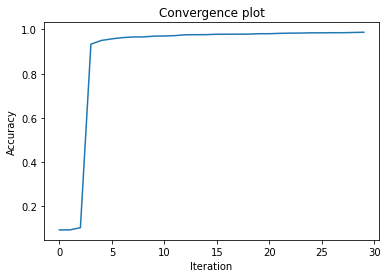

In [23]:
results = study.trials_dataframe()

results['value'].sort_values().reset_index(drop=True).plot()
plt.title('Convergence plot')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')

## Evaluate the model

In [24]:
# load best model

model = load_model(path_best_model)

In [25]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_17 (Conv2D)          (None, 28, 28, 64)        640       
                                                                 
 conv2d_18 (Conv2D)          (None, 28, 28, 64)        36928     
                                                                 
 conv2d_19 (Conv2D)          (None, 28, 28, 64)        36928     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 flatten_8 (Flatten)         (None, 12544)             0         
                                                                 
 dense_26 (Dense)            (None, 176)               2207920   
                                                      

In [26]:
# make predictions in test set

result = model.evaluate(x=X_test,
                        y=y_test)

132/132 [==============================] - 3s 24ms/step - loss: 0.0416 - accuracy: 0.9883


In [27]:
# print evaluation metrics

for name, value in zip(model.metrics_names, result):
    print(name, value)

loss 0.04162285476922989
accuracy 0.9883333444595337


### Confusion matrix

In [28]:
# Predict the values from the validation dataset
y_pred = model.predict(X_test)

# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred, axis = 1)

# Convert validation observations to one hot vectors
y_true = np.argmax(y_test, axis = 1)

# compute the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes) 

cm

array([[415,   0,   0,   1,   1,   0,   2,   0,   3,   0],
       [  0, 471,   0,   0,   0,   0,   1,   1,   0,   0],
       [  0,   2, 404,   0,   0,   0,   1,   0,   2,   0],
       [  0,   0,   1, 419,   0,   2,   1,   3,   0,   0],
       [  1,   2,   0,   0, 425,   0,   1,   0,   0,   0],
       [  0,   0,   0,   1,   0, 378,   2,   0,   1,   0],
       [  0,   0,   0,   0,   2,   0, 409,   0,   0,   1],
       [  0,   1,   2,   0,   0,   1,   0, 465,   0,   0],
       [  0,   1,   0,   0,   0,   1,   5,   0, 377,   0],
       [  1,   0,   0,   0,   2,   0,   0,   2,   1, 388]])

Text(0.5, 13.421126458070283, 'Predicted label')

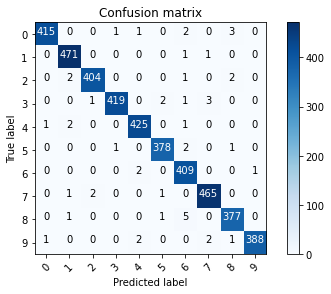

In [29]:
# let's make it more colourful
classes = 10

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(classes)
plt.xticks(tick_marks, range(classes), rotation=45)
plt.yticks(tick_marks, range(classes))

for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
             horizontalalignment="center",
             color="white" if cm[i, j] > 100 else "black",
            )

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')